# **Multiple Linear Regression of the Dataset "cacao.csv"**

## **Installing and Loading Libraries**

Before we can begin with multiple linear regression, we need to install and load the necessary libraries.

First, we update the package installer pip and then install the libraries numpy, pandas, matplotlib, scikit-learn, seaborn, and statsmodels.

Finally, we load the libraries so they can be used.

In [46]:
!python -m pip install --upgrade pip

ERROR: Invalid requirement: '#'


In [17]:
%pip install numpy >nul & pip install pandas >nul & pip install matplotlib >nul & pip install scikit-learn >nul & pip install seaborn >nul & pip install statsmodels >nul

Note: you may need to restart the kernel to use updated packages.


In [1]:
%reset -f

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as smsd
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import plot_partregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **Building the Model**

We do not want to optimize the model at this point; instead, we want to take a closer look at the diagnostics that need to be examined and interpret the results of the model diagnostics.

First, we need to create the model. 

For this, we use "stem_diameter" as the dependent variable and all other variables as predictors. 

In [2]:
df = pd.read_csv('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/Datasets/cacao.csv') # reading in the data
y = df['stem_diameter']
x = df.drop('stem_diameter', axis=1) # axis = 1 to look at columns instead of rows
x = sm.add_constant(x)
model = sm.OLS(y, x).fit() # train the model

# **Diagnostics**

## **Code for Diagnostics**

The model was developed under certain assumptions.

To examine these, we conduct specific diagnostics.

These diagnostics ensure that the assumptions of the model have not been violated.

The following aspects are examined:

a. Non-linearity of data

b. Correlation of error terms

c. Non-constant variance

d. Outliers

e. High-leverage points

f. Collinearity

The code for the plots is sourced from: https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html

In [3]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        # GH#9157
        if plot_context not in plt.style.available:
            plot_context = 'default'
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


In [4]:
cls = LinearRegDiagnostic(model)

## **Diagnostics - Outliers and Incluential Points**

The used measures try to identify observations that are outliers, with large residual, or observations that have a large influence on the regression estimates.

Robust Regression, RLM, can be used to both estimate in an outlier robust way as well as identify outlier.

The advantage of RLM that the estimation results are not strongly influenced even if there are many outliers, while most of the other measures are better in identifying individual outliers and might not be able to identify groups of outliers.

In [6]:
endog = y
exog = x

# Add a constant to the independent variables
exog = sm.add_constant(exog)

# Fit a robust linear model using Huber's T norm
huber_t = sm.RLM(endog, exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()

# Print the weights
print("Weights assigned by the robust linear model (Huber's T norm):")
print(hub_results.weights[hub_results.weights < 1])

Weights assigned by the robust linear model (Huber's T norm):
1      0.996228
5      0.794313
12     0.599257
25     0.618441
27     0.389882
28     0.658364
29     0.944914
31     0.728242
34     0.566903
35     0.450249
36     0.553299
43     0.876507
61     0.902461
73     0.967000
90     0.602708
97     0.830530
107    0.848120
dtype: float64


The first column indicates the row of the dataset in which the potential outlier is located. The second column tells us Huber's T norm

One suggests that the values is not an outlier. The further the value deviates from 1 towards zero, the more likely it is to be an outlier. But to confirm that it is an outlier we should check whether the point is only an influencial point.

Now we want to look at values that highly influence our model. For that we use the plot provided in the code in the "Code for Diagnostics" section.

<Axes: title={'center': 'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>

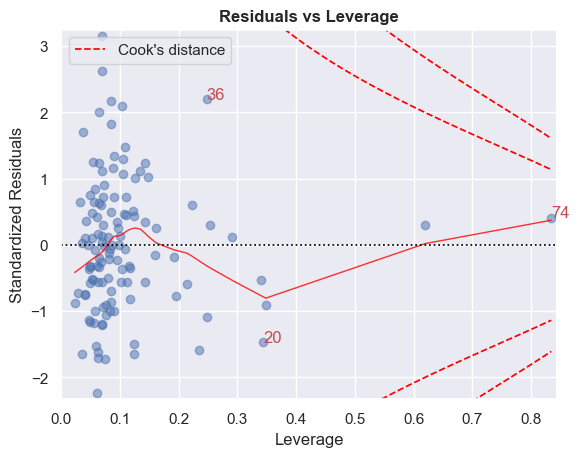

In [7]:
sns.set_theme("notebook")
cls.leverage_plot()
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/leverage_plot.png')

The x-axis shows the levarge and measures the influence of a point's predictor variable on the predicted value. Points with high leverage have values from the predictors that are far from the mean values of the predictors.

The y-axis shows the standardized residuals and measures the residuals divided by their estimated standard deviation.

The red dashed lines represent Cook's distance contours and measures the influence of a point on the fitted values. Points outside these lines can be considered as highly influential.

As we can see the points 36 and 74 are near that contours, so we might suggest that those points are very influential.

Point 20 has a high standardized residual but no high leverage, so we consider this point as a outlier.

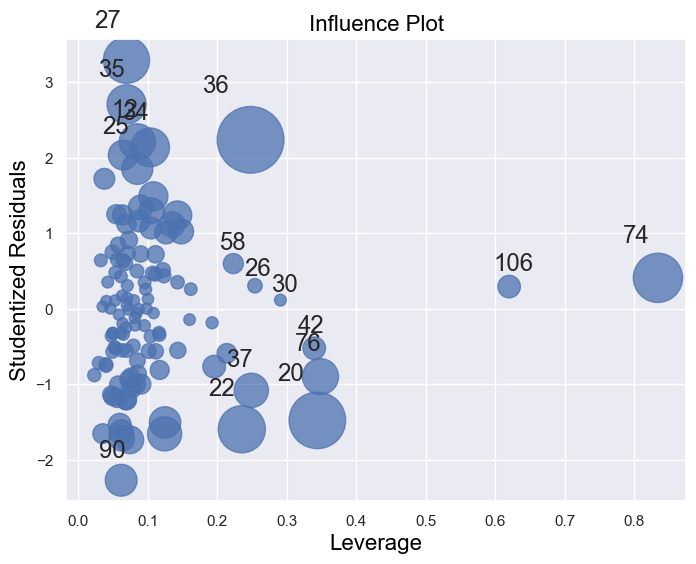

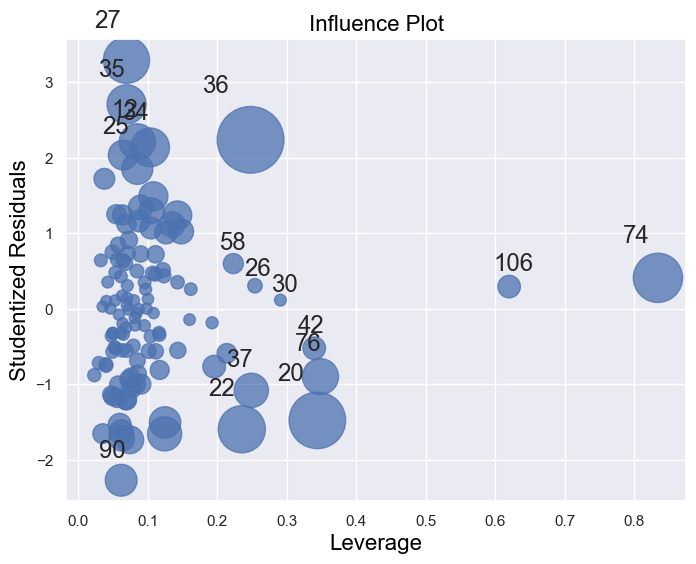

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/influence_plot.png')

The x-axis show the leverage and measures the influence of a data point's predictors values on the predicted values. High leverage points have values of the predictors that are far from the mean values of the predictors.

The y-axis shows the studentized residuals and Measures the size of the residuals, adjusted for the influence of that point. Large residuals indicate that the data point is poorly predicted by the model.

Points with high leverage and large studentized residuals (e.g., point 27) are likely outliers and can have a large impact on the model's parameters.

Points with high leverage and low residuals (e.g., point 74) can still be influential because they are far from the mean of the predictors.

Large points indicate observations with high Cook's distance, showing they have a large impact on the regression coefficients.

Observing the VIF and the influence plot we can suggest that the points 12, 27, 34, 35 and 36 are outliers, because they have a low Huber's t norm and they are points with a low leverage and a high studentized residual.

## **Diagnostics - Non-Linearity of Data**

One of the assumptions that were made for the multiple linear regression is the assumption of linearity. Now we want to check if the given data violate this assumption.

Linearity means that there is a linear relationship between our dependent variable 'stem_diameter' and the predictor variables.

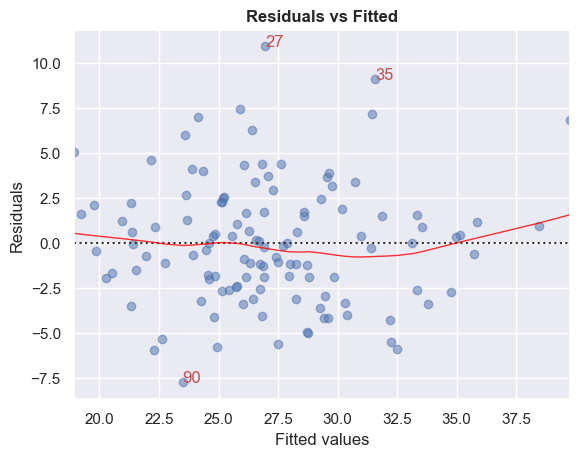

In [15]:
cls.residual_plot();
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/residual_plot.png')

In this plot, the linearity assumption is checked.

**Description of the Plot**

It shows the residuals on the y-axis versus the fitted values from the model on the x-axis.

The dotted black line represents the zero residuals line. Points near the line indicate that the prediction of the model are close to the actual values.

The red line is a smoothed line that visualizes the trend of the residuals.

**Interpretation of the Plot**

The residuals should be randomly distributed around the zero line if the model is correct. Here, you can see that the residuals are randomly distributed. This can be observed from the red line, as it is always close to the dotted line.

We would say that the linearity assumption is not violated. Now we want to show this in a statistical test.

**Harvey-Collier Test**

One test that assesses whether the linearity assumption is violated is the Harvey-Collier Test.

The null hypothesis is that the relationship is linear, so we would suggest that p-values over 0.05 would cause us to reject the null hypothesis. 

The 0.05 p-value threshold is a historical convention that provides a practical balance between the risks of Type I and Type II errors for different types of tests (Literature: Regression (Fahrmeir)).

In [16]:
# Harvey-Collier Test

test_stat, p_value = sms.linear_harvey_collier(model)

# Output the results
print(f'Harvey-Collier test statistic: {test_stat}')
print(f'Harvey-Collier test p-value: {p_value}')

Harvey-Collier test statistic: nan
Harvey-Collier test p-value: nan


As an output we only get 'nan' which might be caused by a high multicollinearity, which will be checked later.

## **Diagnostics - Homoscedasticity**

The homoscedasticity is the assumption in the model that the variance of residuals is constant. If this assumption is violated (heteroscedasticity), the standard errors of the coefficients can be biased.

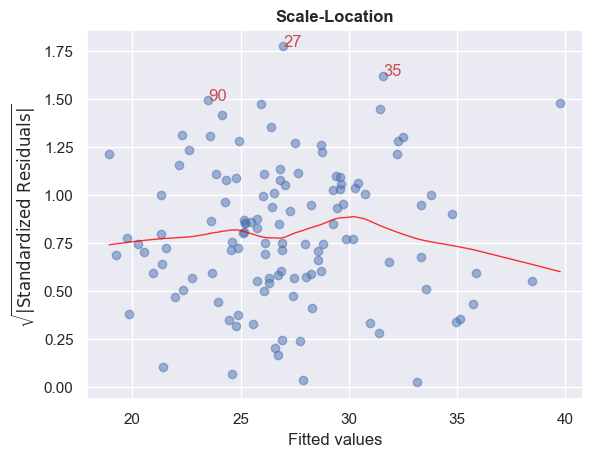

In [17]:
cls.scale_location_plot();
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/scale_location.png')

The x-axis shows the fitted values from the regression model.

The y-axis shows quare root of the standardized residuals. Standardized residuals are the residuals divided by their estimated standard deviation.

The red line is a smooth line fitted through the points. It helps to visualize any patterns or trends in the spread of the residuals.

As we have seen in the previous section the points 27, 35 and 36 are outliers or influential points.

Ideally, the points should be randomly scattered around the red line, indicating that the residuals have constant variance. The points should not follow a certain shape for example like an u-shape or a v-shape.

Here, it seems that the variance of the residuals slightly increases around the fitted values from 25 to 30 which only suggest some degree of heteroscedasticity. We can later check in a test whether it is heteroscedasticity

A statistical test that can be used to examine heteroscedasticity is the Lagrange Multiplier Heteroscedasticity Test by Breusch-Pagan. The null hypothesis is that all observations have the same error variance, i.e. errors are homoscedastic.

In order to show that heteroscedasticity exists we would have to reject the null hypothesis.

In [19]:
test_result = smsd.acorr_breusch_godfrey(model, nlags=1)

# H0: There is no serial correlation in the residuals.
# H1: There is serial correlation in the residuals.

# Output the results
bg_test_stat = test_result[0]
bg_test_pvalue = test_result[1]
print(f'Breusch-Godfrey test statistic: {bg_test_stat}')
print(f'Breusch-Godfrey p-value: {bg_test_pvalue}')

Breusch-Godfrey test statistic: 10.364685086137024
Breusch-Godfrey p-value: 0.001284488083694485


The p-value of < 0.05 indicates that the variance of the residuals is **not** constant across different levels of the predictors, suggesting the presence of heteroscedasticity.


## **Diagnostics - Correlation of Error Terms**

In the model the error terms should not be correlated. In order to show that independancy of error terms we can use the Durbin-Watson test in addition to the optical observation. The values between 1.5 and 2.5 suggest the independancy of error terms.

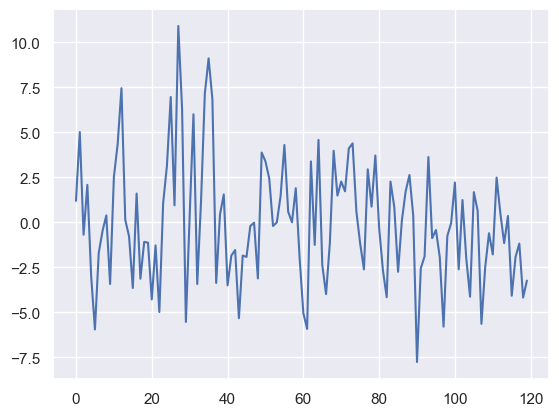

In [20]:
plt.plot(model.resid)
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/resid_vs_index.png')

This plot shows the residuals of the plot (y-axis) and the index of the residuals (x-axis). If the residuals appear to be randomly scattered around the zero line, it suggests that the residuals are independent.

The independancy is suggested by the zig-zag pattern, but is it safe to suggest this only from optical observation?

We want to show it now with the Durbin-Watson Test.

In [21]:
durbin_watson(model.resid)

1.4407171708562327

As we can see the value 1.44 is out of the recommended range of 1.5 - 2.5, so it is not safe to suggest the independancy of errors

## **Diagnostics - Normality of Residuals**

The next assumption that we want to check is the assumption of normality of residuals. We can check this by using the QQ-Plot.

<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

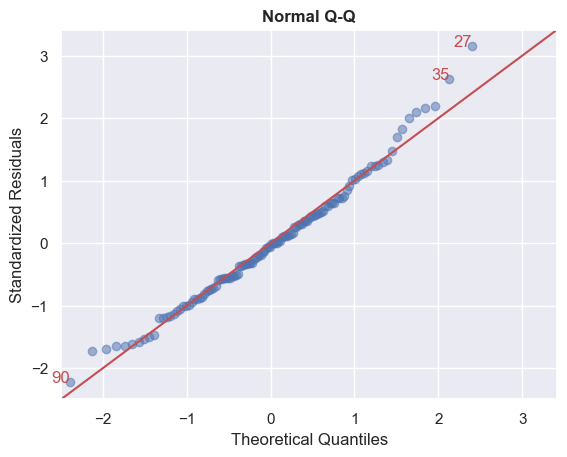

In [23]:
cls.qq_plot()
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/qq_plot.png')

The x-axis represents the theoretical quantiles of the normal distribution.

The y-axis shows the observed quantile from the data.

If the normality assumption is not violated the datapoints should be aligned at the bisector, which is the red line in the plot.

Most points lie close to the red line, but looking at the the beginning and the end of th red line, the points derivate as a tail from the red line. We would say, that the assumption of normal distribution is violated.

The points 27, 35 and 90 deviate from the bisector which suggests that those points have higher residuals than expected under normality. As we have shown earlier, those points might be outliers.

A statistical test that can be used to watch out for normality distribution is the Anderson-Darling Test.

In [26]:
test_stat, p_value = sms.normal_ad(df)

# Output the results
print(f'Anderson-Darling test statistic: {test_stat}')
print(f'Anderson-Darling test p-value: {p_value}')

Anderson-Darling test statistic: [21.39204916  0.80770814  0.86944595  0.7603833   1.68565462  4.29008531
  1.28927589  1.29937142  1.26183861  1.19038385  2.02433748  2.30287958
  2.27892219]
Anderson-Darling test p-value: [8.45283670e-50 3.56232827e-02 2.50339021e-02 4.66890525e-02
 2.39292906e-04 1.01743158e-10 2.28220277e-03 2.15465112e-03
 2.66836349e-03 4.00968583e-03 3.50029614e-05 7.22650542e-06
 8.27580810e-06]


As we can see, this tests strongly suggests that the data do not follow a normal distribution.

The tail that we saw in the qq-plot might be the reason, why the test says that the data do not follow a normal distribution.

## **Diagnostics - Collinearity of Predictors**

The model got issues if the predictors are highly correlated. If they are highly correlated then the scores on the different predictors are not independent.

In order to see if we got multicollinearity in our data we use the Variance Inflation Factor (VIF).

The Variance Inflation Factor (VIF) table is a statistical tool used to assess multicollinearity in a set of regression variables.

Values over 5 imply multicollinearity with other variables (https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html).

In [28]:
cls.vif_table()

,Features,VIF Factor
1,ant_exclusion,1.13
3,canopy,1.33
2,height,1.36
0,const,127.24
5,dw_infect,224.64
10,ab_fl_op,243.00
8,fw_seeds,662.17
11,ab_fl_cl,1175.46
12,ab_fl,2344.46
7,fw_pulb,5845.52


We can suggest, that the variables canopy, height and ant_exclusion are likely to be not highly collinear with the other input variables.

## **Additional Plots**

Besides those plots provided there are other plots that might help looking i.e. for linearity or homoscedacity or to just get to know the dataset. Those plots are provided in this section.

### **Examine Canopy in the Model**

As we have seen in the section "Collinearity of Predictors" the predictors ant_exlusion and canopy are likely not collinear with the other input variables, so we want to examine those further.

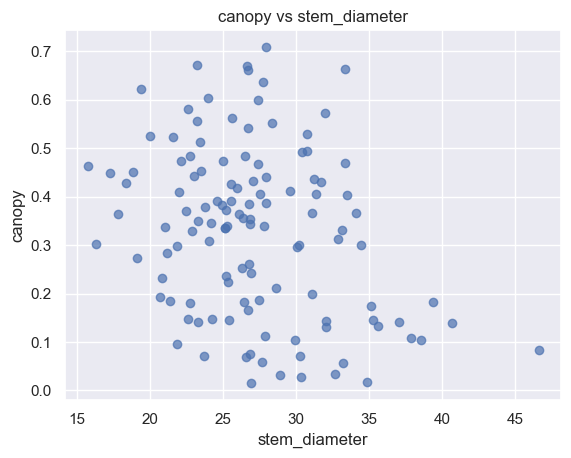

In [29]:
# Plots for canopy

plt.scatter(df['stem_diameter'], df['canopy'], alpha=0.7)
plt.title('canopy vs stem_diameter')
plt.xlabel('stem_diameter')
plt.ylabel('canopy')
plt.grid(True)
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/stem_diameter_vs_canopy.png')

plt.show()

In this plot we plotted canopy (y-axis) against stem_diameter (y-axis).

The points are scattered throughout the plot which indicates that the relationship between those two variables might not be linear.

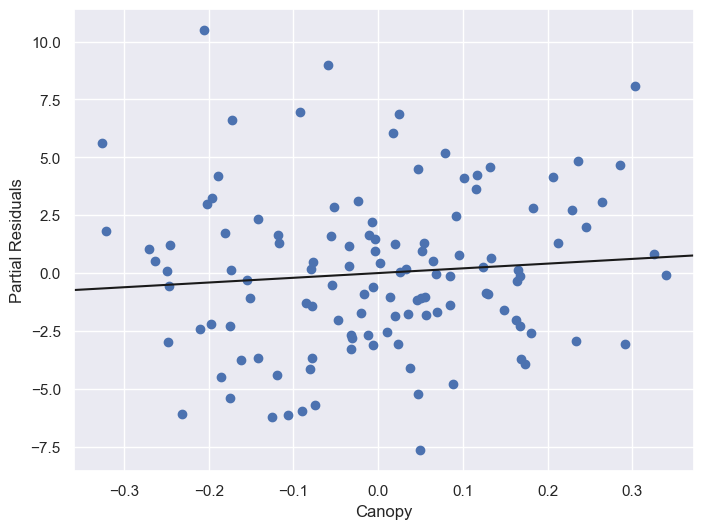

In [30]:
# Partial residual plot for 'canopy'
fig, ax = plt.subplots(figsize=(8, 6))
plot_partregress(endog='y', exog_i='canopy', exog_others=list(x.columns.difference(['const', 'canopy'])), data=df, ax=ax)

# Remove text labels manually
for artist in ax.get_children():
    if isinstance(artist, plt.Text):
        artist.set_visible(False)
        
plt.title('Partial Residual Plot for Canopy')
plt.xlabel('Canopy')
plt.ylabel('Partial Residuals')
#plt.savefig('C:/Users/phleu/Desktop/Bachelorarbeit_PL/LocalRepository_PL/OLSAI/ColabNotebooks/partial_resid_vs_canopy.png')

plt.show()

The x-axis represents the values of the canopy variable.

The y-axis represents the partial residuals, which are the residuals from the regression model adjusted for the effect of the canopy variable.

In this plot we can see that the trend line (black line) has a slight upward slope, which suggests a week positive relationship between stem_diameter and canopy when the influence of the other predictors in the model is removed.